In [162]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import requests
from io import StringIO
import re
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA 
import umap.umap_ as umap
import matplotlib.pyplot as plt
import hdbscan
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import time
import networkx as nx
pd.set_option('display.max_colwidth', None)

In [163]:
dataframe = pd.read_csv("D:\TU\ปี3\DSI314\Project\data1.csv")

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16648\929209161.py:1: SyntaxWarning: invalid escape sequence '\T'
  dataframe = pd.read_csv("D:\TU\ปี3\DSI314\Project\data1.csv")


In [164]:
dataframe.rename(columns={
    "description":"desc",
    "disciplinary course(s)":"add1",
    "consecutive course(s)":"add2",
    "faculty":"ma"
    
})

dataframe.drop(["Unnamed: 0"],axis=1)

,code,description,disciplinary course(s),consecutive course(s),faculty,cancel_course
0,"am360, ma391",discussion on topics of current interest in applied mathematics basic skills for academic reading proposal topic regulations and procedures literature review designing and planning of the project report writing and topic of project presentation,['disciplinary course(s): am260\nstอบได้ am.260 หรือ ได้รับอนุมัติจากผู้บรรยาย'],['consecutive course(s): am460'],sci,"['am260', 'am.260', 'am460']"
1,"at437, at438",biology of animal behaviour behavioural genetics memory and learning foraging and ingestive behaviour social and reproductive behaviour farm animal behaviour regulations and assessment of animal welfare field trips,[],[],sci,[]
2,"cs303, cs401",senior projects will be assigned or approved by the department this course prepares students for developing a proposal for doing research writing research papers and presenting the proposal to the committee,['disciplinary course(s): cs300 and cs301 or\ncs300 and cs302\nstำหรับนักศึกษาตั้งแต่ชั้นปีที่ 3 ขึ้นไป'],['consecutive course(s): cs403'],sci,"['cs300', 'cs301', 'cs300', 'cs302', 'cs403']"
3,"cs369, cs485",basic systems and protocols for providing services on the internet developing and deploying web applications topics covered web application development techniques for both client side and server side session management interfacing with other online services web application security web design patterns and reusable web application components,['disciplinary course(s): cs234 or\ncs322'],[],sci,"['cs234', 'cs322']"
4,"cs379, cs466",deterministic and stochastic grammars morphological analysis syntax analysis semantic analysis discourse analysis and applications (eg machine translation speech recognition and synthesis and text mining),['disciplinary course(s): cs265'],[],sci,['cs265']
...,...,...,...,...,...,...
1828,si474,the main travel and tourism resources; discussions about the barriers and obstacles of the business administration operation change adaptation of the tourism which impact on the situation of tourism in southeast asia,[],[],cis,[]
1829,si477,concepts and principles of recreation: definition development classification and organization of recreational activities,[],[],cis,[]
1830,si478,study of meaning history pattern and management of activities and training techniques for activities and training arrangement facilities and locations evaluation and analysis of activities and training outcome development of training skills and activity leadership facilitator skills instructor skills trainer skills as well as the skills required for individuals in the activity and training job,[],[],cis,[]
1831,si500,research the main areas of student interest while following the suggested student advisor’s guidelines for following the research method for the purpose of research analysis and synthesis of information the course culminates in a presentation of a term paper showing the results of the study research,[],[],cis,[]


In [165]:
model_name = "sentence-transformers/all-MiniLM-L6-v2" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [166]:
model1 = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
model2 = SentenceTransformer('paraphrase-mpnet-base-v2') 
Big_model = SentenceTransformer("all-mpnet-base-v2")

In [169]:
def create_embeddings1():
    dis = list(dataframe["description"])
    embeddings = model1.encode(dis)
    return embeddings
dataframe["embed1"] = create_embeddings1().tolist()

def create_embeddings2():
    dis = list(dataframe["description"])
    embeddings = model2.encode(dis)
    return embeddings
dataframe["embed2"] = create_embeddings2().tolist()

def create_embeddings3():
    dis = list(dataframe["description"])
    embeddings = Big_model.encode(dis)
    return embeddings
dataframe["embed3"] = create_embeddings3().tolist()

embeddings1 = np.array(dataframe["embed1"].tolist())
embeddings2 = np.array(dataframe["embed2"].tolist())
embeddings3 = np.array(dataframe["embed3"].tolist())

In [170]:
dataframe[['code', 'description', 'disciplinary course(s)', 'consecutive course(s)', 'faculty', 'cancel_course','embed1', 'embed2', 'embed3']].to_csv("data_embed.csv")

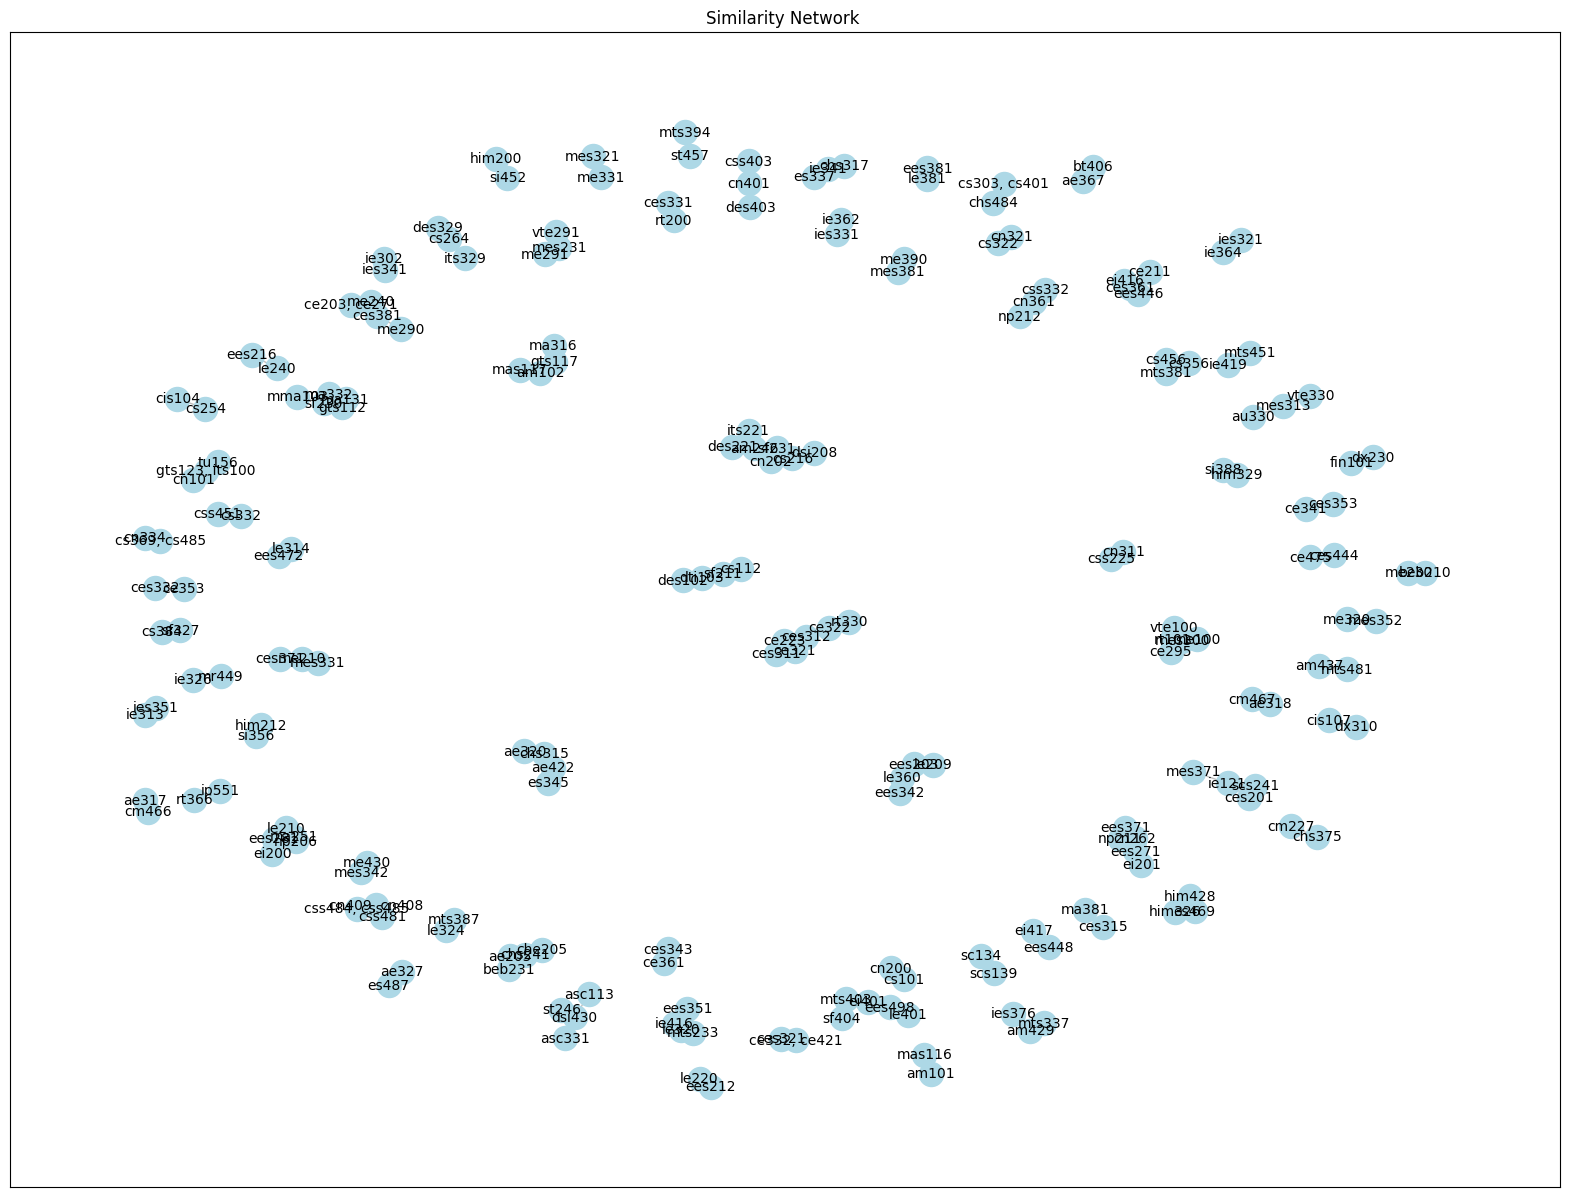

In [171]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# คำนวณค่า cosine similarity สำหรับทุกคู่ของ embeddings
def compute_similarity_matrix1(dataframe, threshold=0.73):
    embeddings = np.vstack(dataframe["embed1"].dropna().to_numpy())   # รวม embeddings เป็น array
    similarity_matrix = cosine_similarity(embeddings)  # คำนวณค่า similarity matrix

    pairs = []
    code_pairs = []
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > threshold:
                course_i = dataframe.iloc[i]["code"]  # Get course code for row i
                course_j = dataframe.iloc[j]["code"]  # Get course code for row j
                cancel_i = dataframe.iloc[i]["cancel_course"]  # Get canceled courses for row i
                cancel_j = dataframe.iloc[j]["cancel_course"]  # Get canceled courses for row j
                ii = dataframe.iloc[i]["faculty"]  # Get canceled courses for row i
                jj = dataframe.iloc[j]["faculty"]  # Get canceled courses for row j


                # Only add the pair if it is not canceled for both courses
                # and jj not in ii and ii not in jj
                if course_j not in cancel_i and course_i not in cancel_j and jj not in ii and ii not in jj:
                    pairs.append((i, j))  # Append the pair if conditions are met
                    code_pairs.append((course_i, course_j))
                    
        dataframe["valid_pairs1"] = dataframe["code"].apply(
            lambda x: [sussssssss for sussssssss in code_pairs if x in sussssssss]
        )
        dataframe["valid_pairs1"] = dataframe.apply(
        lambda row: [pair[0] if pair[1] == row["code"] else pair[1] for pair in row["valid_pairs1"] if row["code"] in pair],
        axis=1
        )

    
    codes = dataframe["code"].tolist()          
    G = nx.Graph()
    G.add_edges_from([(codes[i], codes[j]) for i, j in pairs])  

    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G, seed=42) 
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black") 

    plt.title(f"Similarity Network ")
    plt.show()

    return code_pairs

df["valid_pairs1"] = [[] for _ in range(len(df))]
code_pairs1 = compute_similarity_matrix1(dataframe)

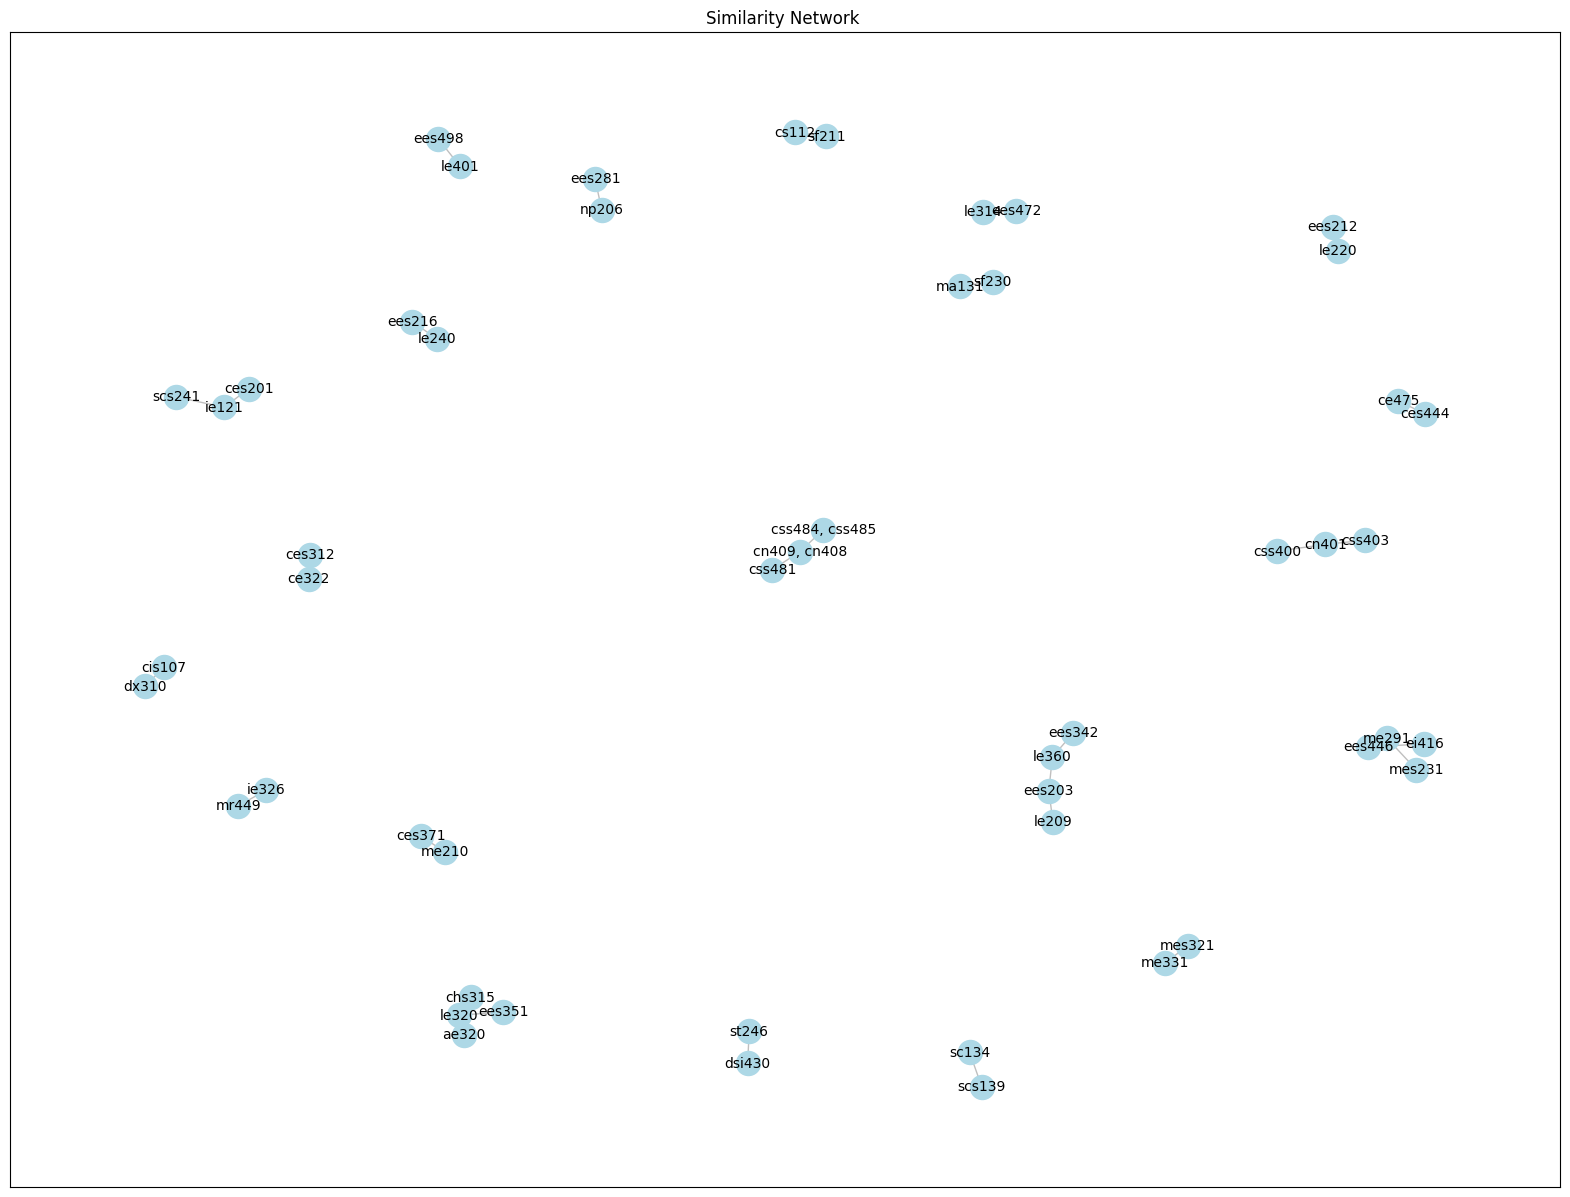

In [172]:
# คำนวณค่า cosine similarity สำหรับทุกคู่ของ embeddings
def compute_similarity_matrix2(dataframe, threshold=0.85):
    embeddings = np.vstack(dataframe["embed2"].dropna().to_numpy())   # รวม embeddings เป็น array
    similarity_matrix = cosine_similarity(embeddings)  # คำนวณค่า similarity matrix

    pairs = []
    code_pairs = []
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > threshold:
                course_i = dataframe.iloc[i]["code"]  # Get course code for row i
                course_j = dataframe.iloc[j]["code"]  # Get course code for row j
                cancel_i = dataframe.iloc[i]["cancel_course"]  # Get canceled courses for row i
                cancel_j = dataframe.iloc[j]["cancel_course"]  # Get canceled courses for row j
                ii = dataframe.iloc[i]["faculty"]  # Get canceled courses for row i
                jj = dataframe.iloc[j]["faculty"]  # Get canceled courses for row j

                # Only add the pair if it is not canceled for both courses
                # and jj not in ii and ii not in jj
                if course_j not in cancel_i and course_i not in cancel_j and jj not in ii and ii not in jj:
                    pairs.append((i, j))  # Append the pair if conditions are met
                    code_pairs.append((course_i, course_j))
                    
        dataframe["valid_pairs2"] = dataframe["code"].apply(
            lambda x: [sussssssss for sussssssss in code_pairs if x in sussssssss]
        )
        dataframe["valid_pairs2"] = dataframe.apply(
        lambda row: [pair[0] if pair[1] == row["code"] else pair[1] for pair in row["valid_pairs2"] if row["code"] in pair],
        axis=1
        )

    
    codes = dataframe["code"].tolist()          
    G = nx.Graph()
    G.add_edges_from([(codes[i], codes[j]) for i, j in pairs])  

    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G, seed=42) 
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black") 

    plt.title(f"Similarity Network ")
    plt.show()

    return code_pairs

df["valid_pairs2"] = [[] for _ in range(len(df))]
code_pairs2 = compute_similarity_matrix2(dataframe)

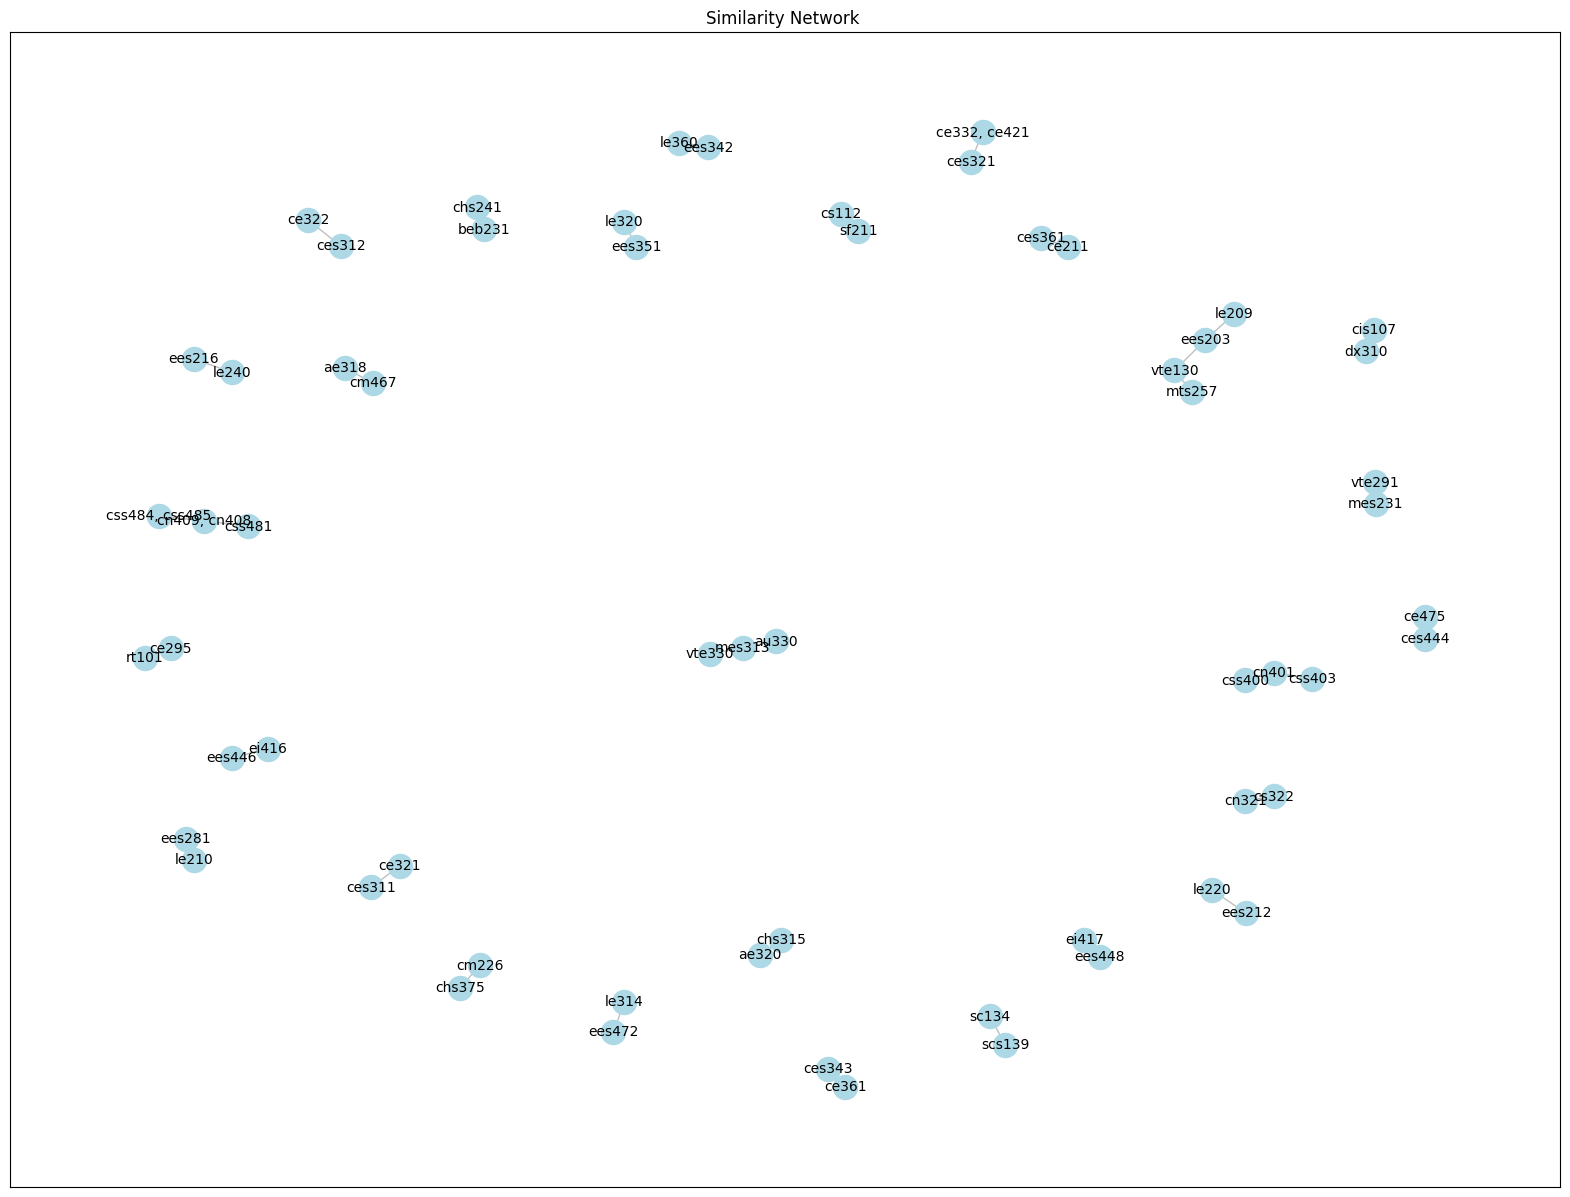

In [173]:

# คำนวณค่า cosine similarity สำหรับทุกคู่ของ embeddings
def compute_similarity_matrix3(dataframe, threshold=0.87):
    embeddings = np.vstack(dataframe["embed3"].dropna().to_numpy())   # รวม embeddings เป็น array
    similarity_matrix = cosine_similarity(embeddings)  # คำนวณค่า similarity matrix

    pairs = []
    code_pairs = []
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > threshold:
                course_i = dataframe.iloc[i]["code"]  # Get course code for row i
                course_j = dataframe.iloc[j]["code"]  # Get course code for row j
                cancel_i = dataframe.iloc[i]["cancel_course"]  # Get canceled courses for row i
                cancel_j = dataframe.iloc[j]["cancel_course"]  # Get canceled courses for row j
                ii = dataframe.iloc[i]["faculty"]  # Get canceled courses for row i
                jj = dataframe.iloc[j]["faculty"]  # Get canceled courses for row j


                # Only add the pair if it is not canceled for both courses
                # and jj not in ii and ii not in jj
                if course_j not in cancel_i and course_i not in cancel_j and jj not in ii and ii not in jj:
                    pairs.append((i, j))  # Append the pair if conditions are met
                    code_pairs.append((course_i, course_j))
                    
        dataframe["valid_pairs3"] = dataframe["code"].apply(
            lambda x: [sussssssss for sussssssss in code_pairs if x in sussssssss]
        )
        dataframe["valid_pairs3"] = dataframe.apply(
        lambda row: [pair[0] if pair[1] == row["code"] else pair[1] for pair in row["valid_pairs3"] if row["code"] in pair],
        axis=1
        )
    
    codes = dataframe["code"].tolist()          
    G = nx.Graph()
    G.add_edges_from([(codes[i], codes[j]) for i, j in pairs])  

    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G, seed=42) 
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black") 

    plt.title(f"Similarity Network ")
    plt.show()

    return code_pairs

df["valid_pairs3"] = [[] for _ in range(len(df))]
code_pairs3 = compute_similarity_matrix3(dataframe)

In [174]:
print(code_pairs1)
print(code_pairs2)
print(code_pairs3)

[('cs303, cs401', 'chs484'), ('cs369, cs485', 'cn334'), ('ce203, ce271', 'ces381'), ('ce332, ce421', 'ces321'), ('cn409, cn408', 'css484, css485'), ('cn409, cn408', 'css481'), ('gts123, its100', 'tu156'), ('gts123, its100', 'cn101'), ('am101', 'mas116'), ('am102', 'gts117'), ('am102', 'mas117'), ('am246', 'cn202'), ('am246', 'sf231'), ('am246', 'des221'), ('am246', 'its221'), ('am437', 'mts481'), ('bt406', 'ae367'), ('cm466', 'ae317'), ('cs112', 'sf211'), ('cs254', 'cis104'), ('dti103', 'sf211'), ('dti103', 'des102'), ('es337', 'ie341'), ('es469', 'him326'), ('es469', 'him428'), ('es487', 'ae327'), ('fin101', 'dx230'), ('ma131', 'sf230'), ('ma131', 'gts112'), ('ma251', 'ei200'), ('ma332', 'sf230'), ('ma332', 'gts112'), ('ma381', 'ces315'), ('mr449', 'ie326'), ('np212', 'cn361'), ('rt101', 'me100'), ('rt101', 'ce295'), ('rt101', 'vte100'), ('rt101', 'mes300'), ('rt200', 'ces331'), ('rt366', 'ip551'), ('sc134', 'scs139'), ('st457', 'mts394'), ('asc113', 'dsi430'), ('beb231', 'ae205'), ('

In [152]:
dataframe[dataframe["code"] == "cn311"][["code","desc","ma","valid_pairs1"]]

KeyError: "['desc', 'ma'] not in index"

In [151]:
dataframe[dataframe["code"] == "css225"][["code","desc",'ma',"valid_pairs1"]]

KeyError: "['desc', 'ma'] not in index"

In [141]:
dataframe.rename(columns={
    "desc":"description",
    "add1":"disciplinary course(s)",
    "add2":"consecutive course(s)",
    "ma":"faculty"
},inplace=True)

In [175]:
dataframe["valid_pairs1"] = dataframe["valid_pairs1"].apply(lambda x: [item.replace("'", "") for item in x])
dataframe["valid_pairs2"] = dataframe["valid_pairs2"].apply(lambda x: [item.replace("'", "") for item in x])
dataframe["valid_pairs3"] = dataframe["valid_pairs3"].apply(lambda x: [item.replace("'", "") for item in x])

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1828   NaN
1829   NaN
1830   NaN
1831   NaN
1832   NaN
Name: valid_pairs1, Length: 1833, dtype: float64

In [176]:
dataframe.columns
dataframe.to_csv("final_1.csv")

In [187]:
dataframe[["code","valid_pairs1","faculty"]].head()

,code,valid_pairs1,faculty
0,"am360, ma391",[],sci
1,"at437, at438",[],sci
2,"cs303, cs401",[chs484],sci
3,"cs369, cs485",[cn334],sci
4,"cs379, cs466",[],sci


In [239]:
dataframe[dataframe["code"] == "rt330"][["code","description","valid_pairs1","faculty"]]

,code,description,valid_pairs1,faculty
820,rt330,type of structures structural behavior loads structural analysis of statically determinate structures and trusses by simple methods shear force and bending moment of beams computer programs aided structural analysis field trips,[ce322],sci


In [217]:
df1 = dataframe
df2 = dataframe
matching_rows = df1[df1['code'].apply(lambda x: any(x in sublist for sublist in df2['valid_pairs1']))]


df2["valid_pairs1"] = df2["valid_pairs1"].apply(lambda x: [item.replace("'", "") for item in x])
df2['matches'] = df2['valid_pairs1'].apply(lambda x: any(code in x for code in df1['code']))

In [220]:
df2["valid_pairs1"].head()

0          []
1          []
2    [chs484]
3     [cn334]
4          []
Name: valid_pairs1, dtype: object

In [228]:
df2[df2['matches'] == True][["code","description","valid_pairs1"]]

,code,description,valid_pairs1
2,"cs303, cs401",senior projects will be assigned or approved by the department this course prepares students for developing a proposal for doing research writing research papers and presenting the proposal to the committee,[chs484]
3,"cs369, cs485",basic systems and protocols for providing services on the internet developing and deploying web applications topics covered web application development techniques for both client side and server side session management interfacing with other online services web application security web design patterns and reusable web application components,[cn334]
17,"ce203, ce271",properties of fluid; fluid static; momentum and energy equations; equation of continuity and motion; similitude and dimensional analysis; flow in pipes; flow measurement; steady incompressible flow,[ces381]
19,"ce332, ce421",elastic and strength properties of wood; design of beams compression members tension members joints; codes and specifications of steel design of both asd and lrfd; design of tension members beams and plate girder columns beam-columns built-up members and steel frames; design of bolted riveted and welded connections; design practice and detailing of steel and timber structures,[ces321]
24,"cn409, cn408",topics of current interest and new developments in various fields in computer engineering,"[css484, css485, css481]"
...,...,...,...
1715,ip551,theories and practices of economics related to sustainability; classic economic development theories and alternative development frameworks; concepts and debates associated with sustainable development; key economic social and environment issues such as green and blue economy energy and climate change; and economic policies and regulations for sustainable development,[rt366]
1763,si452,concepts and definitions of cultural industry; the development of western and eastern cultural industries; culture as new boundary of national and international co-operation; creative economy and cultural products; as well as cultural products opportunities,[him200]
1778,dsi208,analysis of running time and memory requirements data structures: arrays linked lists stacks queues trees hash graph algorithm techniques: brute force divide-and-conquer greedy algorithms and dynamic programming space and time tradeoffs algorithm design and implementation for business problems testing and debugging,[cs216]
1817,si356,the development and concepts of socio-cultural resource management at national and international levels the course focuses on the role of government agencies organizations and other sectors in socio-cultural resource management; as well as the impacts of development and management,[him212]


In [243]:
a = len(df2)
round(a/3)

611